In [2]:
!pip install -q kaggle
!pip install -q einops

In [4]:
import os
import shutil

# Create the .kaggle folder
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json into it
shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

# Set permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

print("✅ Kaggle API key set up!")


✅ Kaggle API key set up!


In [5]:
!kaggle datasets download -d dronio/SolarEnergy

Dataset URL: https://www.kaggle.com/datasets/dronio/SolarEnergy
License(s): DbCL-1.0
  0% 0.00/511k [00:00<?, ?B/s]
100% 511k/511k [00:00<00:00, 1.09GB/s]


In [6]:
import zipfile
import os

# Unzip the downloaded file
with zipfile.ZipFile("SolarEnergy.zip", "r") as zip_ref:
    zip_ref.extractall("solar_data")


In [7]:
import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from einops import rearrange

In [8]:
#Load Dataset
file_path = "solar_data/SolarPrediction.csv"  # Adjust if needed
df = pd.read_csv(file_path)
df['Time'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])
df = df.sort_values('Time')
df.set_index('Time', inplace=True)

<ipython-input-8-3328500991>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])


In [9]:
# Feature Engineering
features = ['Temperature', 'Humidity', 'Pressure', 'WindDirection(Degrees)', 'Speed']
target = 'Radiation'

In [10]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + [target]]), columns=features + [target], index=df.index)


In [11]:
# Create Dataset for Transformer
sequence_length = 24

In [12]:
class SingleStepSolarDataset(Dataset):
    def __init__(self, data, seq_len=24):
        self.X, self.y = [], []
        for i in range(len(data) - seq_len):
            self.X.append(data[i:i+seq_len, :len(features)])  # Feature columns
            self.y.append(data[i+seq_len, len(features)])     # Only Radiation (index 0 in targets)
        self.X = np.array(self.X)
        self.y = np.array(self.y).reshape(-1, 1)  # Ensure shape is (N, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


In [13]:
X = df_scaled.values
sequence_length = 24
dataset = SingleStepSolarDataset(X, seq_len=sequence_length)
train_size = int(len(dataset) * 0.8)
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)


In [14]:
class SLTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, output_dim=1):
        super(SLTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        out = x[:, -1, :]     # Take last time step
        out = self.fc(out)
        return out


In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
input_dim = len(features)
model = SLTransformer(input_dim=input_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 0.0608
Epoch 2/20, Loss: 0.0119
Epoch 3/20, Loss: 0.0093
Epoch 4/20, Loss: 0.0081
Epoch 5/20, Loss: 0.0080
Epoch 6/20, Loss: 0.0076
Epoch 7/20, Loss: 0.0073
Epoch 8/20, Loss: 0.0071
Epoch 9/20, Loss: 0.0072
Epoch 10/20, Loss: 0.0068
Epoch 11/20, Loss: 0.0067
Epoch 12/20, Loss: 0.0065
Epoch 13/20, Loss: 0.0064
Epoch 14/20, Loss: 0.0064
Epoch 15/20, Loss: 0.0061
Epoch 16/20, Loss: 0.0062
Epoch 17/20, Loss: 0.0061
Epoch 18/20, Loss: 0.0060
Epoch 19/20, Loss: 0.0059
Epoch 20/20, Loss: 0.0058


In [16]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y_batch.numpy())

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")
#Lower MSE and MAE values are better. For this dataset, MSE < 0.01 and MAE < 0.08 are generally considered good after normalization.

MSE: 0.0067, MAE: 0.0469


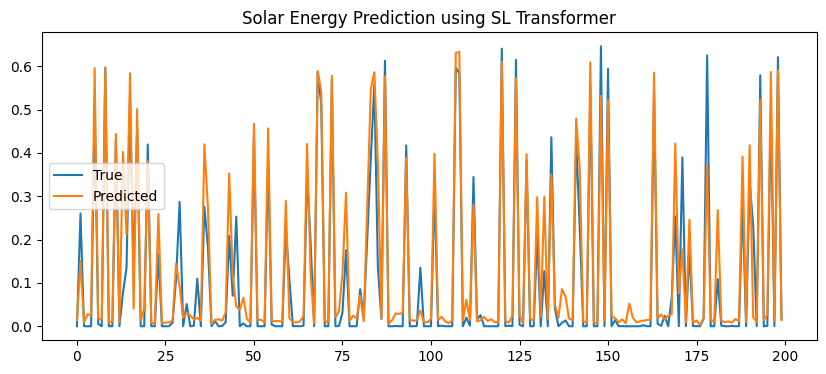

In [19]:
# Step 10: Plotting
plt.figure(figsize=(10, 4))
plt.plot(y_true[:200], label='True')
plt.plot(y_pred[:200], label='Predicted')
plt.legend()
plt.title("Solar Energy Prediction using SL Transformer")
plt.show()

In [25]:
# Step 1: Install & Import Libraries
!pip install -q kaggle
!pip install -q einops

import zipfile
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from einops import rearrange


# Step 4: Load Dataset
file_path = "solar_data/SolarPrediction.csv"
df = pd.read_csv(file_path)
df['Time'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])
df = df.sort_values('Time')
df.set_index('Time', inplace=True)

# Step 5: Feature Engineering
features = ['Temperature', 'Humidity', 'Pressure', 'WindDirection(Degrees)', 'Speed']
targets = ['Radiation', 'Speed']  # Solar + Wind

input_dim = len(features)
target_dim = len(targets)

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[features + targets]), columns=features + targets, index=df.index)

# Step 6: Create Dataset for Multi-Step Forecasting
sequence_length = 24
forecast_steps = 6

class MultiStepSolarDataset(Dataset):
    def __init__(self, data, seq_len=24, forecast_steps=6):
        self.X, self.y = [], []
        for i in range(len(data) - seq_len - forecast_steps):
            self.X.append(data[i:i+seq_len, :input_dim])  # Only feature columns
            self.y.append(data[i+seq_len:i+seq_len+forecast_steps, input_dim:])  # Only target columns
        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

X = df_scaled.values
dataset = MultiStepSolarDataset(X, seq_len=sequence_length, forecast_steps=forecast_steps)
train_size = int(len(dataset) * 0.8)
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64)

# Step 7: Modified SL Transformer for Multi-Step Multi-Output Forecasting
class MultiStepSLTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, forecast_steps=6, target_dim=2):
        super(MultiStepSLTransformer, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, forecast_steps * target_dim)
        self.forecast_steps = forecast_steps
        self.target_dim = target_dim

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        out = x[:, -1, :]  # Last time step
        out = self.fc(out)
        return out.view(-1, self.forecast_steps, self.target_dim)

model = MultiStepSLTransformer(input_dim=input_dim, forecast_steps=forecast_steps, target_dim=target_dim).to('cuda' if torch.cuda.is_available() else 'cpu')


<ipython-input-25-1181472386>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Data'] + ' ' + df['Time'])


In [21]:
# Step 8: Training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.0204
Epoch 2/20, Loss: 0.0085
Epoch 3/20, Loss: 0.0076
Epoch 4/20, Loss: 0.0071
Epoch 5/20, Loss: 0.0068
Epoch 6/20, Loss: 0.0066
Epoch 7/20, Loss: 0.0064
Epoch 8/20, Loss: 0.0063
Epoch 9/20, Loss: 0.0061
Epoch 10/20, Loss: 0.0061
Epoch 11/20, Loss: 0.0060
Epoch 12/20, Loss: 0.0058
Epoch 13/20, Loss: 0.0057
Epoch 14/20, Loss: 0.0056
Epoch 15/20, Loss: 0.0056
Epoch 16/20, Loss: 0.0055
Epoch 17/20, Loss: 0.0054
Epoch 18/20, Loss: 0.0053
Epoch 19/20, Loss: 0.0053
Epoch 20/20, Loss: 0.0052


In [26]:
# Step 9: Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).cpu().numpy()
        y_pred.append(preds)
        y_true.append(y_batch.numpy())

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)


In [27]:
# Only evaluating on Radiation prediction (index 0)
mse = mean_squared_error(y_true[:, :, 0].flatten(), y_pred[:, :, 0].flatten())
mae = mean_absolute_error(y_true[:, :, 0].flatten(), y_pred[:, :, 0].flatten())
print(f"Multi-step Radiation - MSE: {mse:.4f}, MAE: {mae:.4f}")


Multi-step Radiation - MSE: 0.2828, MAE: 0.4157


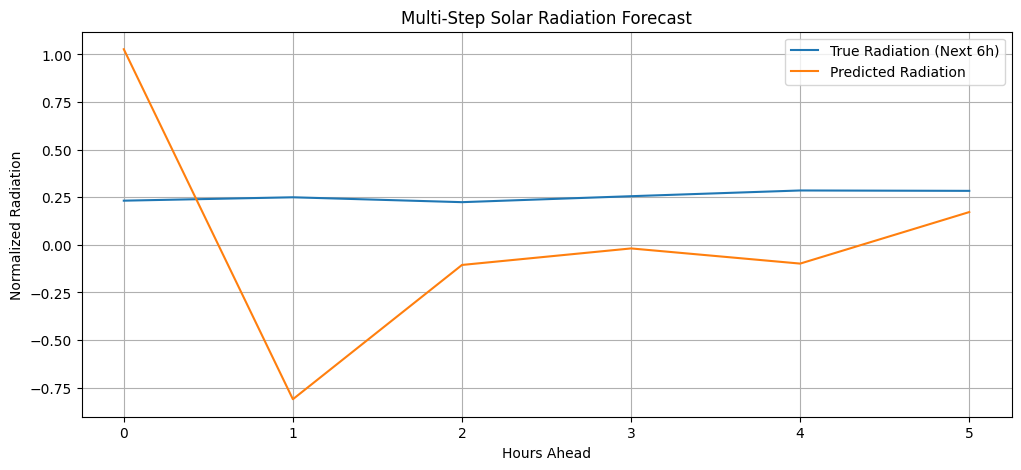

In [28]:
# Step 10: Plotting Sample Forecast
plt.figure(figsize=(12, 5))
plt.plot(y_true[0, :, 0], label='True Radiation (Next 6h)')
plt.plot(y_pred[0, :, 0], label='Predicted Radiation')
plt.title("Multi-Step Solar Radiation Forecast")
plt.xlabel("Hours Ahead")
plt.ylabel("Normalized Radiation")
plt.legend()
plt.grid()
plt.show()